# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy, tqdm

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm

import experiment_settings
import file_methods, plots, data_processing, custom_metrics

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME_VEC = ('exp11C_370','exp15C_370','exp15C_126','exp20C_370','exp20C_126','exp1','exp2','exp3', 'exp4','exp5','exp6','exp7')
PLOT_SEED = 1257

LOOP_THROUGH_EXP = True
SAVE_FILE = True
LOAD_METRICS = True

#-------------------------------------------------------

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Plotting Functions

In [4]:
FS = 10
palette=("tab:gray","tab:purple","tab:orange","tab:blue","tab:red","tab:green",)

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get obs

In [5]:
# load observations for diagnostics plotting
settings = experiment_settings.get_settings("exp15C_370")
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Analyze CMIP results across random seeds

In [6]:
df_metrics = pd.DataFrame()
if LOAD_METRICS == True:
    df_metrics = pd.read_pickle(DATA_DIRECTORY + "df_random_seed.pickle")

    
if LOOP_THROUGH_EXP == True:
    for exp_name in EXP_NAME_VEC:
        settings = experiment_settings.get_settings(exp_name)
        rng = np.random.default_rng(settings["rng_seed"])    
        print(exp_name)

        for iloop in np.arange(settings['n_models']):
            seed = rng.integers(low=1_000,high=10_000,size=1)[0]
            settings["seed"] = int(seed)
            tf.random.set_seed(settings["seed"])
            np.random.seed(settings["seed"])

            # check if entry exists
            entry = df_metrics[(df_metrics["exp_name"]==exp_name) & (df_metrics["seed"]==settings["seed"])]
            if len(entry) > 0:
                continue
            
            # get model name
            model_name = file_methods.get_model_name(settings)
            if os.path.exists(MODEL_DIRECTORY + model_name + "_model") == False:               
                continue
            model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)
            # get the data
            (x_train, 
             x_val, 
             x_test, 
             y_train, 
             y_val, 
             y_test, 
             onehot_train, 
             onehot_val, 
             onehot_test, 
             y_yrs_train, 
             y_yrs_val, 
             y_yrs_test, 
             target_years, 
             map_shape,
             settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

            #----------------------------------------        
            # make predictions for observations and cmip results
            pred_train = model.predict(x_train)
            pred_val = model.predict(x_val)
            pred_test = model.predict(x_test) 
            pred_obs = model.predict(x_obs)

            #----------------------------------------  
            # plot PIT histogram
            if settings["seed"] == PLOT_SEED:
                fig, ax = plt.subplots(1,1)
                plots.plot_pits(ax, x_val=x_val, onehot_val=onehot_val,  model_shash = model)
                format_spines(plt.gca())
                plt.savefig(FIGURE_DIRECTORY + model_name + '_pit' + '.png', 
                            bbox_inches="tight",
                            dpi=savefig_dpi)
                # plt.show()
                plt.close()


            #----------------------------------------        
            # compute metrics to compare
            error_val = np.mean(np.abs(pred_val[:,0] - onehot_val[:,0]))
            error_test = np.mean(np.abs(pred_test[:,0] - onehot_test[:,0]))    
            __, __, d_val, __ = custom_metrics.compute_pit(onehot_val, x_data=x_val, model_shash = model)
            __, __, d_test, __ = custom_metrics.compute_pit(onehot_test, x_data=x_test, model_shash = model)    

            d = {}
            d["exp_name"] = settings["exp_name"]
            d["seed"] = settings["seed"]
            d["hiddens"] = str(settings["hiddens"])
            d["ridge_param"] = settings["ridge_param"][0]        
            d["error_val"] = error_val
            d["error_test"] = error_test
            d["d_val"] = d_val
            d["d_test"] = d_test
            d["obs_2021_mu"] = pred_obs[-1][0]
            d["obs_2021_sigma"] = pred_obs[-1][1]            

            df = pd.DataFrame(d, index=[0])
            df_metrics = pd.concat([df_metrics,df])

    df_metrics = df_metrics.sort_values("ridge_param")        
    df_metrics = df_metrics.drop_duplicates(ignore_index=True)
    
    if SAVE_FILE:
        df_metrics.to_pickle(DATA_DIRECTORY + "df_random_seed.pickle")
        
    display(df_metrics)

exp11C_370


2022-03-24 08:45:20.397489: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test,obs_2021_mu,obs_2021_sigma
0,exp6,6613,"[10, 10]",0.0,3.892594,4.006415,0.026581,0.037464,19.265892,10.246552
1,exp6,6421,"[10, 10]",0.0,3.429899,3.374875,0.021753,0.025936,17.258301,13.142725
2,exp6,6111,"[10, 10]",0.0,3.729452,3.374363,0.024580,0.028943,15.582345,11.026121
3,exp6,9983,"[10, 10]",0.0,3.771115,3.739270,0.018486,0.027377,16.966526,8.777010
4,exp6,3301,"[10, 10]",0.0,3.459950,3.005947,0.028421,0.014841,16.188744,6.865798
...,...,...,...,...,...,...,...,...,...,...
295,exp7,1939,"[10, 10]",1000.0,4.119872,3.783711,0.019820,0.027791,13.414199,6.726826
296,exp7,5322,"[10, 10]",1000.0,4.381805,4.511510,0.013687,0.017746,13.800038,6.885042
297,exp7,4348,"[10, 10]",1000.0,4.262570,4.009819,0.014276,0.034822,13.521201,6.482028
298,exp7,3301,"[10, 10]",1000.0,4.569134,4.295606,0.011794,0.023288,13.945155,7.082397


## Random seeds for obs

In [20]:
df_metrics.iloc[iplot]

,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test,obs_2021_mu,obs_2021_sigma
92,exp11C_370,9156,"[10, 10]",1.0,3.966107,3.746395,0.019885,0.025491,2.191942,7.445037
107,exp11C_370,1257,"[10, 10]",1.0,2.739501,3.181788,0.013383,0.022450,-0.460934,6.383921
124,exp11C_370,9983,"[10, 10]",1.0,3.889383,3.799042,0.022729,0.020812,3.199272,8.170292
125,exp11C_370,4348,"[10, 10]",1.0,3.591062,3.344250,0.019734,0.037793,2.706123,7.432007
126,exp11C_370,5869,"[10, 10]",1.0,3.129934,3.225046,0.018636,0.028117,2.031178,6.196654
131,exp11C_370,3316,"[10, 10]",1.0,3.089856,3.195918,0.018410,0.039147,-0.320086,6.230271
132,exp11C_370,6111,"[10, 10]",1.0,3.434506,3.117359,0.011170,0.024720,0.008204,7.025498
133,exp11C_370,3301,"[10, 10]",1.0,3.377623,3.047231,0.015908,0.013804,2.169981,6.389638
134,exp11C_370,6421,"[10, 10]",1.0,3.232301,3.559119,0.026686,0.021619,0.585985,7.898581
140,exp11C_370,5322,"[10, 10]",1.0,3.121786,3.275800,0.017746,0.032599,-1.690592,5.309876


In [35]:
np.random.normal(0,.01,len(iplot))

array([-0.01409907, -0.01491064,  0.00373297,  0.01737503, -0.00234663,
       -0.01833978, -0.01497863,  0.0100617 , -0.00929856, -0.01171372,
        0.00179545,  0.01032572,  0.00105417, -0.00482617,  0.01312381,
       -0.00271568, -0.01225023,  0.01890188,  0.01868658,  0.00151555])

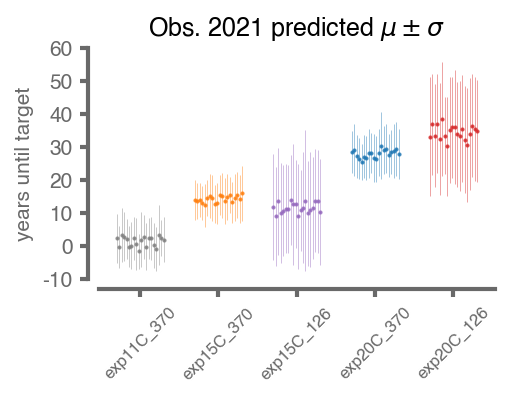

In [73]:
# PLOT ACROSS SSPs and TARGETS

EXP_FOR_PLOTTING = ('exp11C_370','exp15C_370','exp15C_126','exp20C_370','exp20C_126')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("exp_name")
clr_order = [0,2,1,3,4,5]
rng_plot = np.random.default_rng(43)
#------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(3.5,2.75))

for iexp,exp_name in enumerate(EXP_FOR_PLOTTING):
    iplot = np.where(df_metrics["exp_name"]==exp_name)[0]
    
    ax.errorbar(np.ones(iplot.shape)*iexp+np.linspace(-.3,.3,len(iplot)),
            df_metrics.iloc[iplot]["obs_2021_mu"],
            yerr=df_metrics.iloc[iplot]["obs_2021_sigma"],
            color=np.array(palette)[clr_order][iexp],
            marker='.',
            linestyle='',
            elinewidth=.25,
            markersize=2,
            alpha=.8,
           )

ax.set_ylabel('years until target')
ax.set_title('Obs. 2021 predicted $\mu \pm \sigma$')
ax.set_xlabel(None)
format_spines(ax)
x_labels = EXP_FOR_PLOTTING
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.set_yticks(np.arange(-100,100,10),np.arange(-100,100,10).round())
ax.set_ylim(-10,60)

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'obs_params_ssp_target_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


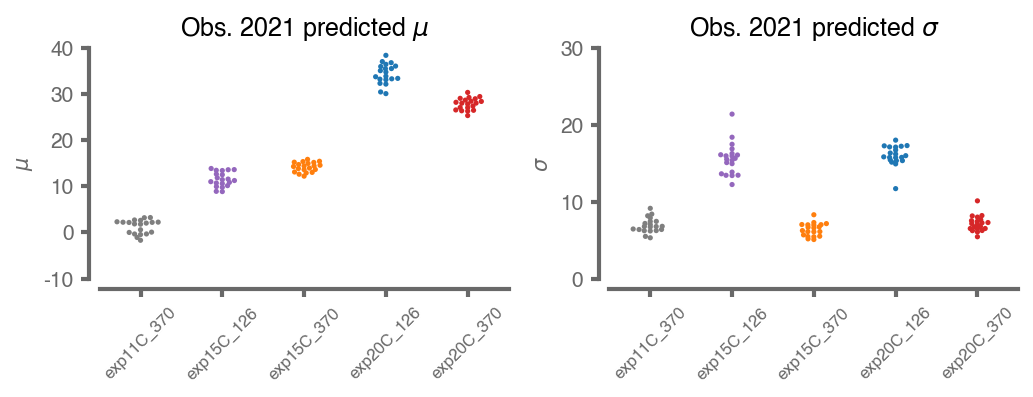

In [7]:
# PLOT ACROSS SSPs and TARGETS

EXP_FOR_PLOTTING = ('exp11C_370','exp15C_370','exp15C_126','exp20C_370','exp20C_126')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("exp_name")
clr_order = [0,1,2,3,4,5]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_xlabel(None)
format_spines(ax)
x_labels = df_metrics_plot["exp_name"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.set_yticks(np.arange(-100,100,10),np.arange(-100,100,10).round())
ax.set_ylim(-10,40)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],              
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(0,30)
ax.set_xlabel(None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
x_labels = df_metrics_plot["exp_name"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
# plt.savefig(FIGURE_DIRECTORY + 'obs_params_ssp_target_comparison' + '.png', 
#             bbox_inches="tight",
#             dpi=savefig_dpi)
plt.show()


## Plots across hyperparameters

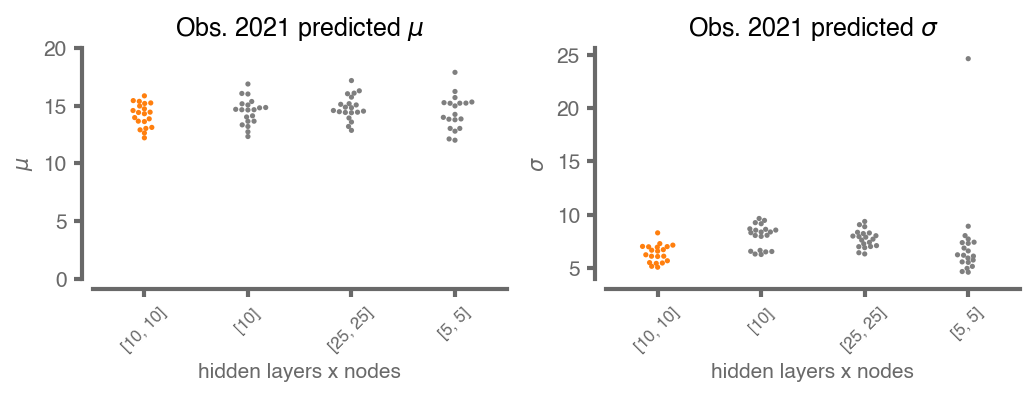

In [8]:
# PLOT ACROSS HIDDEN CHOICES

EXP_FOR_PLOTTING = ('exp15C_370','exp10','exp11','exp12')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("hiddens")
clr_order = [2,0,0,0,0]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_ylim(0.0,20.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(4,None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'obs_params_hiddens_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


### Plots across obs predictions

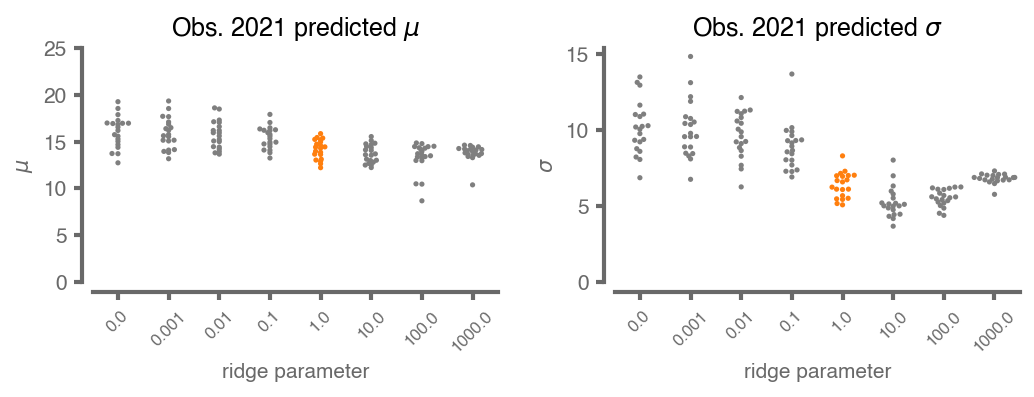

In [9]:
# PLOT ACROSS RIDGE CHOICES

EXP_FOR_PLOTTING = ('exp15C_370','exp1','exp2','exp3', 'exp4','exp5','exp6','exp7')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
clr_order = [0,0,0,0,2,0,0,0,]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_ylim(0.0,25.0)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(0,None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'obs_params_ridge_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


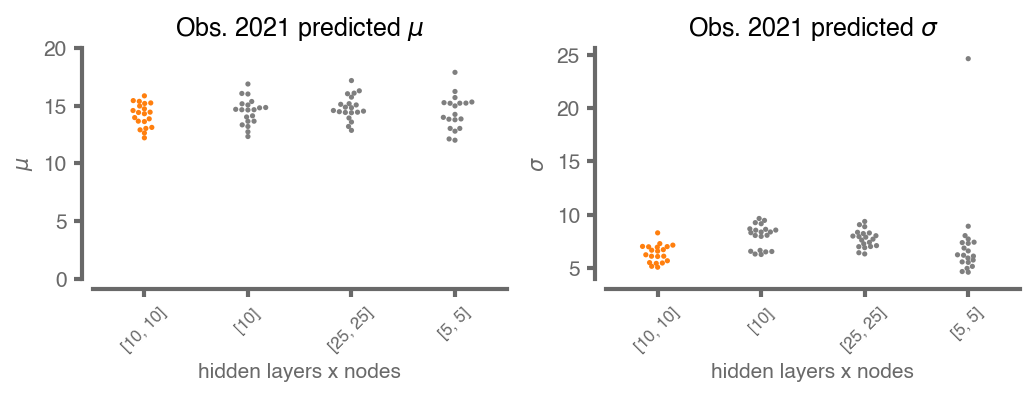

In [10]:
# PLOT ACROSS HIDDEN CHOICES

EXP_FOR_PLOTTING = ('exp15C_370','exp10','exp11','exp12')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("hiddens")
clr_order = [2,0,0,0,0,0,0,0,]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_ylim(0.0,20.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(4,None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'obs_params_hiddens_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


### Error and PIT

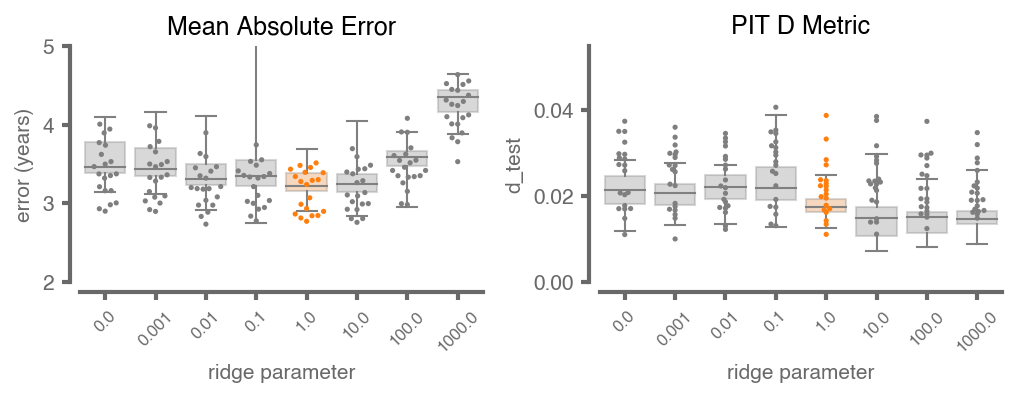

In [11]:
# PLOT ACROSS RIDGE CHOICES

EXP_FOR_PLOTTING = ('exp15C_370','exp1','exp2','exp3', 'exp4','exp5','exp6','exp7')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
clr_order = [0,0,0,0,2,0,0,0,]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            palette=np.array(palette)[clr_order],
            data=df_metrics_plot,
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              palette=np.array(palette)[clr_order],
              data=df_metrics_plot,
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.0,5.0)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.055)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'cmip6_metrics_ridge_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


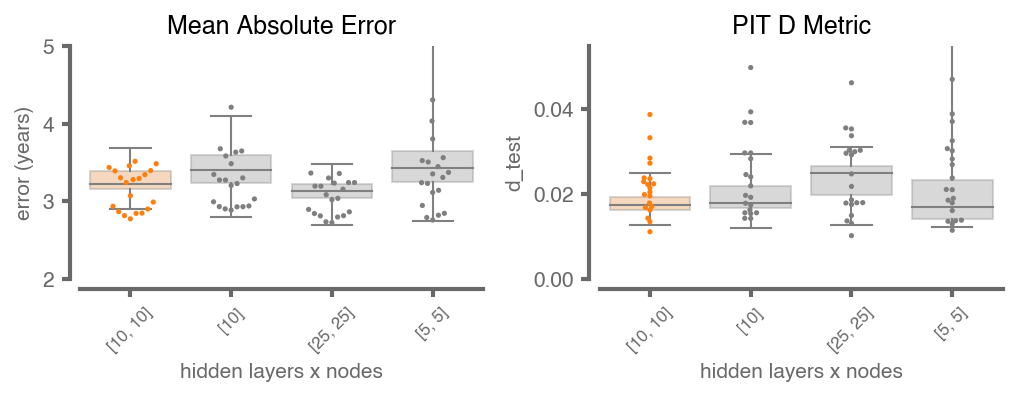

In [12]:
# PLOT ACROSS HIDDEN CHOICES

EXP_FOR_PLOTTING = ('exp15C_370','exp10','exp11','exp12')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("hiddens")
clr_order = [2,0,0,0,0,0,0,0,]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.0,5.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.055)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
x_labels = df_metrics_plot["hiddens"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'cmip6_metrics_hiddens_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


## Explore the dataframe

In [13]:
# display(df_metrics[df_metrics["exp_name"]=="exp15C_370"])
# display(df_metrics[df_metrics["exp_name"]=="exp3"])

display(df_metrics[df_metrics["exp_name"]=="exp15C_370"].median())
display(df_metrics[df_metrics["exp_name"]=="exp3"].median())

seed              5813.000000
ridge_param          1.000000
error_val            3.224544
error_test           3.258667
d_val                0.017460
d_test               0.020977
obs_2021_mu         14.356831
obs_2021_sigma       6.418606
dtype: float64

seed              5813.000000
ridge_param         10.000000
error_val            3.250078
error_test           3.122212
d_val                0.014957
d_test               0.023084
obs_2021_mu         13.644045
obs_2021_sigma       5.065939
dtype: float64

In [14]:
VAL_SEED_DICT = {'exp15C_370': 1257,
                  'exp11C_370': 1257,                  
                  'exp20C_370': 1257,
                  'exp15C_126': 1257,
                  'exp20C_126': 2247,
                  'exp20C_126_uniform': np.nan,                  
}
TEST_SEED_DICT = {'exp15C_370': 8992,
                  'exp11C_370': 8992,                  
                  'exp20C_370': 8992,
                  'exp15C_126': 5757,
                  'exp20C_126': 6195,
                  'exp20C_126_uniform': np.nan,                  
}

display(df_metrics[df_metrics["exp_name"]=="exp20C_126"].sort_values("error_test"))

,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test,obs_2021_mu,obs_2021_sigma
106,exp20C_126,6195,"[10, 10]",1.0,7.609612,6.760265,0.016165,0.024540,30.105558,14.919529
103,exp20C_126,2247,"[10, 10]",1.0,6.584828,6.865625,0.022118,0.018700,33.319260,11.704098
130,exp20C_126,1939,"[10, 10]",1.0,7.682534,6.951959,0.013787,0.044555,33.245209,16.719051
108,exp20C_126,9983,"[10, 10]",1.0,8.036953,7.227965,0.016344,0.029324,35.082031,15.991579
94,exp20C_126,3301,"[10, 10]",1.0,7.224575,7.343643,0.023329,0.024513,32.335640,17.106451
158,exp20C_126,5757,"[10, 10]",1.0,7.779786,7.484046,0.020532,0.048667,35.539959,16.201994
90,exp20C_126,4348,"[10, 10]",1.0,8.343280,7.538769,0.018057,0.032086,37.052906,15.146972
226,exp20C_126,6263,"[10, 10]",1.0,7.287307,7.559244,0.022510,0.015646,34.781635,15.438797
123,exp20C_126,6111,"[10, 10]",1.0,7.532574,7.566571,0.027026,0.038708,33.765739,15.836263
175,exp20C_126,1257,"[10, 10]",1.0,7.268134,7.574885,0.029024,0.030258,33.881474,17.130987
